In [631]:
""" 
MIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb

The features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)
"""

' \nMIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb\n\nThe features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)\n'

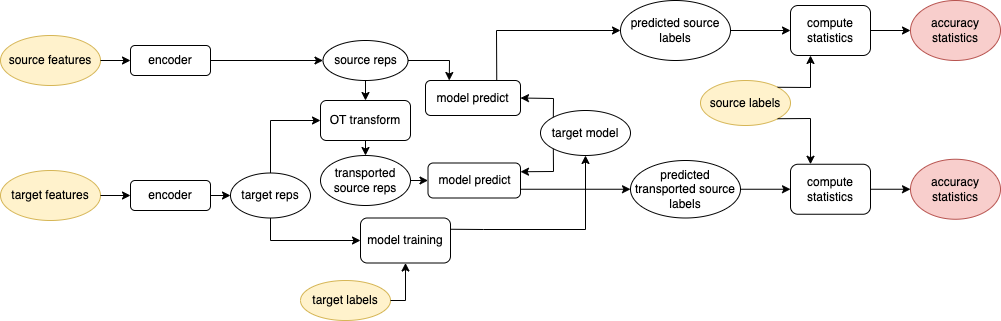

In [1]:
from IPython.display import Image
Image(filename='../../outputs/pipeline_figs/EHR_MIMIC_pipeline.png')

In [95]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
from ast import literal_eval
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [96]:
""" 
Read in dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[1, 5, 9]",530460.0,LEG PAIN,0
173633,EMERGENCY,F,[9],574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[26, 27]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,[31],1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[27, 26, 34, 35]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[47, 34, 31]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[103, 47, 45, 31, 35, 430]",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[44, 103, 47, 250, 62, 45, 35]",692940.0,STROKE;TELEMETRY,0


In [97]:
def select_df(df, male_count, female_count):
    """ 
    Select row in the dataframe df with balanced number of labels for males and females
    Specifically, we want to reduce the number of rows with label 0 for males and females

    :param Dataframe df: the dataframe to select samples with label 0 and label 1
    :param int target_count: the number of samples with label 1s and label 0s for target (male). 
    :param int source_count: the number of samples with label 1s and label 0s for source (female). 
    """

    female_1_indices = []
    female_0_indices = []
    male_1_indices = []
    male_0_indices = []

    for index, row in df.iterrows():
        if row['label'] == 0 and row['gender'] == 'F':
            female_0_indices.append(index)
        elif row['label'] == 0 and row['gender'] == 'M':
            male_0_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'F':
            female_1_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'M':
            male_1_indices.append(index)
    
    # indices to delete from the dataframe
    # sample the same number of label 0s and label 1s
    delete_female_0_indices = random.sample(female_0_indices, len(female_0_indices)-female_count)
    delete_male_0_indices = random.sample(male_0_indices, len(male_0_indices)-male_count)
    delete_female_1_indices = random.sample(female_1_indices, len(female_1_indices)-female_count)
    delete_male_1_indices = random.sample(male_1_indices, len(male_1_indices)-male_count)

    delete_female_0_indices.extend(delete_male_0_indices)
    delete_female_0_indices.extend(delete_female_1_indices)
    delete_female_0_indices.extend(delete_male_1_indices)
    
    new_df = df.drop(delete_female_0_indices, axis=0, inplace=False)
    return new_df


In [190]:
male_count = 120
female_count = 10
admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)


""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])


female label 0 10
female label 1 10
male label 0 120
male label 1 120


In [191]:
def update_codes(df):
    """ 
    Update code in dataframe, the new code starts from 0.
    We use -1 to denote NA code in later analysis

    returns
        - a new dataframe with the updated codes
        - total number of unique codes in df
    """
    new_code_dict = {} # mapping from old code to new code
    for index, row in df.iterrows():
        cur_codes = row['ICD codes']
        new_codes = []
        for code in cur_codes:
            if code not in new_code_dict:
                new_code_dict[code] = len(new_code_dict) # add a new entry
            new_codes.append(new_code_dict[code])
        df.at[index, 'ICD codes'] = new_codes
    return df, len(new_code_dict)


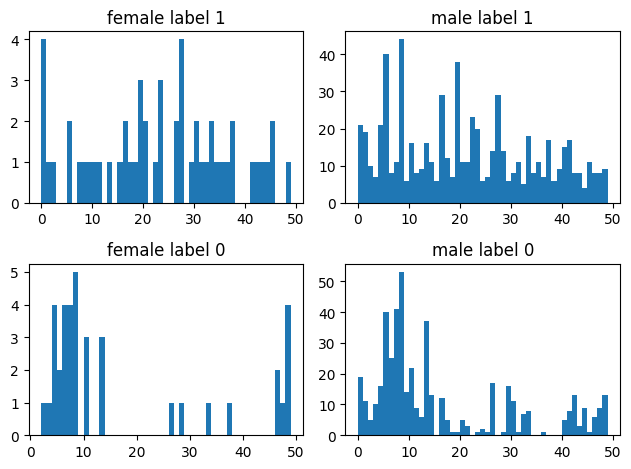

In [192]:
""" 
Plot code distribution for males and females
"""
admid_diagnosis_select_df, _ = update_codes(admid_diagnosis_select_df)
# print(admid_diagnosis_df)
female_1_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')]
male_1_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')]
female_0_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')]
male_0_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')]
bin_width = 1

plt.subplot(2,2,1)
female_1_codes = female_1_df['ICD codes']
female_1_codes = [code for sublist in female_1_codes for code in sublist]
plt.hist(female_1_codes, bins=range(min(female_1_codes), max(female_1_codes)+bin_width, bin_width))
plt.title("female label 1")

plt.subplot(2,2,2)
male_1_codes = male_1_df['ICD codes']
male_1_codes = [code for sublist in male_1_codes for code in sublist]
plt.hist(male_1_codes, bins=range(min(male_1_codes), max(male_1_codes)+bin_width, bin_width))
plt.title("male label 1")

plt.subplot(2,2,3)
female_0_codes = female_0_df['ICD codes']
female_0_codes = [code for sublist in female_0_codes for code in sublist]
plt.hist(female_0_codes, bins=range(min(female_0_codes), max(female_0_codes)+bin_width, bin_width))
plt.title("female label 0")

plt.subplot(2,2,4)
male_0_codes = male_0_df['ICD codes']
male_0_codes = [code for sublist in male_0_codes for code in sublist]
plt.hist(male_0_codes, bins=range(min(male_0_codes), max(male_0_codes)+bin_width, bin_width))
plt.title("male label 0")

plt.tight_layout()
plt.show()


In [193]:
""" 
Question 1: How to select source and target samples such that the embedding learned are different?

We expect that the code distribution of source and target to be very different 

Question 2: Why need embedding?
"""

' \nQuestion 1: How to select source and target samples such that the embedding learned are different?\n\nWe expect that the code distribution of source and target to be very different \n\nQuestion 2: Why need embedding?\n'

In [194]:
def generate_features_labels(df):
    """ 
    Generate source features, source labels, target features and target labels from dataframe df

    TODO: consider making the labels balanced (currently way more 0s than 1s)
    """

    df, num_codes = update_codes(df)

    source_df = df.loc[df['gender'] == 'F']
    target_df = df.loc[df['gender'] == 'M']

    # Prepare target
    target_features = np.empty(shape=[target_df.shape[0], num_codes])
    feature_index = 0
    for index, row in target_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        target_features[feature_index] = code_ind
        feature_index += 1
    target_labels = np.array(list(target_df['label']))

    # Prepare source
    source_features = np.empty(shape=[source_df.shape[0], num_codes])
    feature_index = 0
    for index, row in source_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        source_features[feature_index] = code_ind
        feature_index += 1
    source_labels = np.array(list(source_df['label']))

    return target_features, target_labels, source_features, source_labels


In [195]:
target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)


In [196]:
target_features.shape, target_labels.shape, source_features.shape, source_labels.shape

((240, 50), (240,), (20, 50), (20,))

In [197]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=10)
    target_pca = PCA(n_components=10)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    return target_reps, source_reps

In [198]:
target_reps, source_reps = custom_train_reps(target_features, source_features)


In [199]:
target_reps.shape, source_reps.shape

((240, 10), (20, 10))

In [200]:
""" 
Fit the model, transport and make predictions
"""
clf = LogisticRegression()
# clf = SVC(kernel='rbf')
# clf = SVC()
clf.fit(target_reps, target_labels)
target_preds = clf.predict(target_reps)
source_preds = clf.predict(source_reps)
trans_source_reps = trans_source2target(source_reps, target_reps)
trans_source_preds = clf.predict(trans_source_reps)

In [201]:
# """ 
# Unbalanced OT
# """
# a = np.ones((female_count*2,)) / female_count*2
# b = np.ones((male_count*2,)) / male_count*2
# print("a shape is:", a.shape)
# print("b shape is:", b.shape)
# M = ot.dist(source_reps, target_reps)
# M /= M.max()
# print("M shape is:", M.shape)

# reg = 0.005
# reg_m_kl = 10
# # reg_m_l2 = 5
# # mass = 0.7

# coupling = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m_kl)
# # kl_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
# # l2_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')
# # coupling = ot.partial.partial_wasserstein(a, b, M, m=mass)
# print("source_reps shape is:", source_reps.shape)
# print("target_reps shape is:", target_reps.shape)
# print("coupling shape is:", coupling.shape)
# trans_source_reps = np.transpose(np.matmul(np.transpose(target_reps), np.transpose(coupling)))
# print("trans_source_reps shape is:", trans_source_reps.shape)
# trans_source_preds = clf.predict(trans_source_reps)

# np.savetxt("../../outputs/mimic/target_reps.txt", target_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/source_reps.txt", source_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/trans_source_reps.txt", trans_source_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/coupling.txt", coupling)


In [202]:
""" 
Print the accuracy stats
"""

print("target accuracy is:", accuracy_score(target_labels, target_preds))
print("target precision is:", precision_score(target_labels, target_preds))
print("target recall is:", recall_score(target_labels, target_preds))
print("source accuracy is:", accuracy_score(source_labels, source_preds))
print("source precision is:", precision_score(source_labels, source_preds))
print("source recall is:", recall_score(source_labels, source_preds))
print("trans source accuracy is:", accuracy_score(source_labels, trans_source_preds))
print("trans source precision is:", precision_score(source_labels, trans_source_preds))
print("trans source recall is:", recall_score(source_labels, trans_source_preds))

target accuracy is: 0.8583333333333333
target precision is: 0.8771929824561403
target recall is: 0.8333333333333334
source accuracy is: 0.6
source precision is: 0.6
source recall is: 0.6
trans source accuracy is: 0.65
trans source precision is: 0.6363636363636364
trans source recall is: 0.7


In [219]:
""" 
Automate this process
"""

def entire_proc():
    male_count = 120
    female_count = 10
    admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)

    target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)

    target_reps, source_reps = custom_train_reps(target_features, source_features)

    clf = LogisticRegression()
    clf.fit(target_reps, target_labels)
    target_preds = clf.predict(target_reps)
    source_preds = clf.predict(source_reps)
    trans_source_reps = trans_source2target(source_reps, target_reps)
    trans_source_preds = clf.predict(trans_source_reps)


    target_accuracy = accuracy_score(target_labels, target_preds)
    # target_precision = precision_score(target_labels, target_preds)
    # target_recall = recall_score(target_labels, target_preds)
    target_f1 = f1_score(target_labels, target_preds)
    source_accuracy = accuracy_score(source_labels, source_preds)
    # source_precision = precision_score(source_labels, source_preds)
    # source_recall = recall_score(source_labels, source_preds)
    source_f1 = f1_score(source_labels, source_preds)
    trans_source_accuracy = accuracy_score(source_labels, trans_source_preds)
    # trans_source_precision = precision_score(source_labels, trans_source_preds)
    # trans_source_recall = recall_score(source_labels, trans_source_preds)
    trans_source_f1 = f1_score(source_labels, trans_source_preds)
    return target_accuracy, target_f1, source_accuracy, source_f1, \
        trans_source_accuracy, trans_source_f1



In [225]:
def multi_proc(iteration=20):
    res = np.empty(shape=[iteration, 6])
    for i in range(iteration):
        cur_res = entire_proc()
        res[i] = cur_res
    res_df = pd.DataFrame(res, columns = ['target_accuracy', 'target_f1', 'source_accuracy', 'source_f1', 'trans_source_accuracy', 'trans_source_f1'])
    res_df.to_csv("../../outputs/mimic/score.csv", index=False, header=True)
    return res
    

In [229]:
res = multi_proc(iteration=100)

number of stats is: 95
number of 0 in incre is: 26
number of elements > 0 is: 43
number of elements < 0 is: 26
average trans source to source accuracy increment is: 0.02052631578947368
median trans source to source accuracy increment is: 0.0
average trans source to source accuracy f1 is: 0.01944631230789318
median trans source to source accuracy f1 is: 0.01298701298701288
average trans source to source accuracy is: 1.054905942011205
median trans source to source accuracy is: 1.0
average trans source to source f1 is: 1.0498477381473845
median trans source to source f1 is: 1.0476190476190472


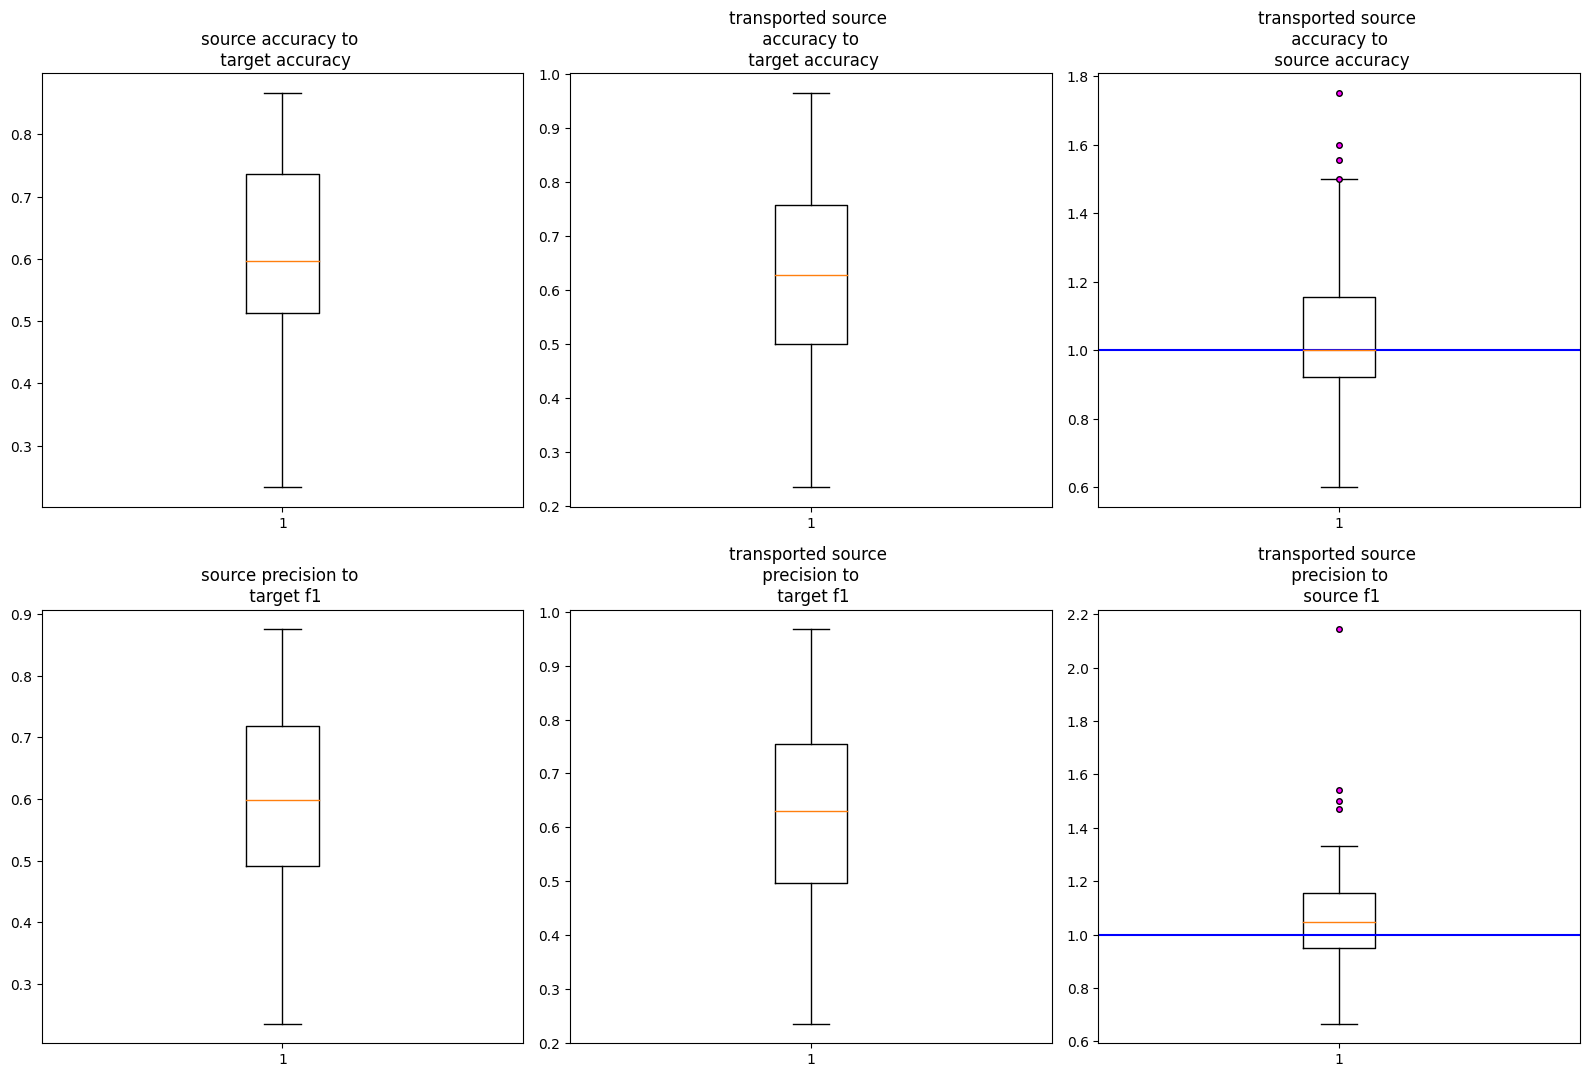

In [230]:
box_plot("../../outputs/mimic/score.csv")

average trans source to source accuracy increment is 2.1%
median trans source to source accuracy increment is 0.0%
average trans source to source accuracy f1 is 1.9%
median trans source to source accuracy f1 is 1.3%


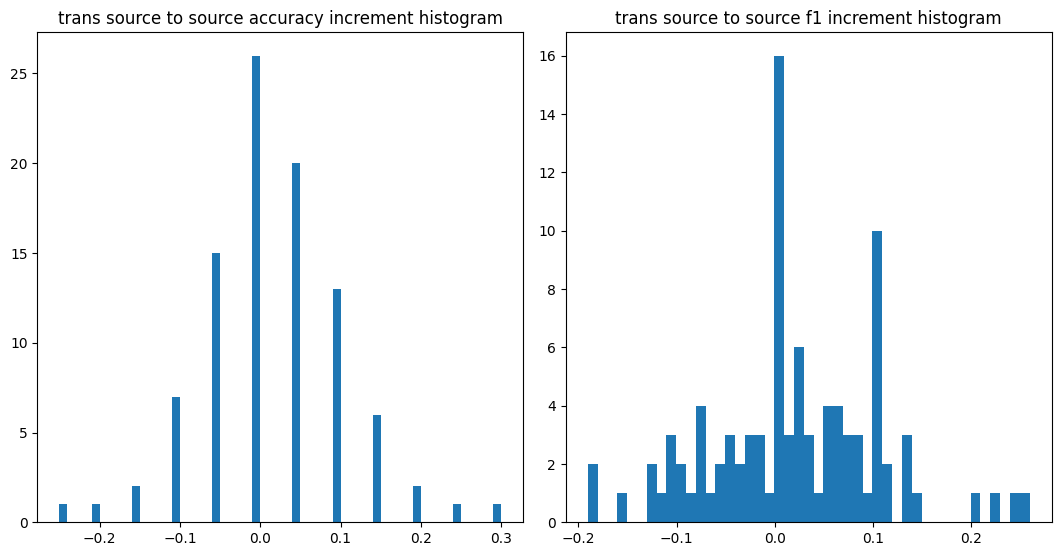

In [231]:
hist_plot("../../outputs/mimic/score.csv")

In [895]:
def vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps):
    """ 
    Visualize the embedding space of dimension 3 for target represenatations, source representations, \
        transported source representations with different labels annotated in different colors
    """
    fig = plt.figure(figsize=[10, 4])

    ax = fig.add_subplot(1,3,1, projection='3d')
    cdict = {1: 'purple', 0: 'orange'}
    
    for l in np.unique(target_labels):
        ix = np.where(target_labels == l)
        ax.scatter(target_reps[ix, 0], target_reps[ix, 1], target_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Target")

    ax = fig.add_subplot(1,3,2, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(source_reps[ix, 0], source_reps[ix, 1], source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Source")

    ax = fig.add_subplot(1,3,3, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(trans_source_reps[ix, 0], trans_source_reps[ix, 1], trans_source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Trans source")
    
    plt.show()
    


In [205]:
entire_proc()


target accuracy is: 0.8625
target precision is: 0.8849557522123894
target recall is: 0.8333333333333334
source accuracy is: 0.7
source precision is: 0.75
source recall is: 0.6
trans source accuracy is: 0.75
trans source precision is: 0.7777777777777778
trans source recall is: 0.7


In [896]:
# vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps)

In [897]:
# # fig = plt.figure()

# # ax = fig.add_subplot(1,3,1, projection='3d')
# plt.figure(figsize=(10, 50))
# plt.scatter(target_reps[:, 0], target_reps[:, 1], target_reps[:, 2], c=target_labels)
# plt.title("Target")
# plt.show()

In [898]:

# # creating 3d plot using matplotlib 
# # in python
  
# # for creating a responsive plot
# %matplotlib notebook
  
# # importing required libraries
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
  
# # creating random dataset
# xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
#       44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
  
# ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
#       5, 2, 4, 1, 8, 7, 0, 5]
  
# zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
#       3, 4, 5, 6, 7, 8, 9, 0]
  
# # creating figure
# fig = plt.figure()
# ax = Axes3D(fig)
  
# # creating the plot
# plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')
  
# # displaying the plot
# plt.show()

In [899]:
# %matplotlib notebook
# # aka import ipympl

# import matplotlib.pyplot as plt

# plt.plot([0, 1, 2, 2])
# plt.show()

In [900]:
""" 
Fit the model (on features), transport and make predictions
"""
clf = LogisticRegression()
# clf = SVC()
clf.fit(target_features, target_labels)
target_preds = clf.predict(target_features)
source_preds = clf.predict(source_features)

# trans_source_features = trans_source2target(source_features, target_features)

ot_emd = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=10000)
# ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=source_features, Xt=target_features)
trans_source_features = ot_emd.transform(Xs=source_features)

trans_source_preds = clf.predict(trans_source_features)

np.savetxt("../../outputs/mimic/target_features.txt", target_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/source_features.txt", source_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/trans_source_features.txt", trans_source_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/coupling.txt", ot_emd.coupling_)


In [901]:
""" 
Focus on this
Print the accuracy stats
"""

print("target accuracy is:", accuracy_score(target_labels, target_preds))
print("target precision is:", precision_score(target_labels, target_preds))
print("target recall is:", recall_score(target_labels, target_preds))
print("source accuracy is:", accuracy_score(source_labels, source_preds))
print("source precision is:", precision_score(source_labels, source_preds))
print("source recall is:", recall_score(source_labels, source_preds))
print("trans source accuracy is:", accuracy_score(source_labels, trans_source_preds))
print("trans source precision is:", precision_score(source_labels, trans_source_preds))
print("trans source recall is:", recall_score(source_labels, trans_source_preds))

target accuracy is: 0.96
target precision is: 0.9893617021276596
target recall is: 0.93
source accuracy is: 1.0
source precision is: 1.0
source recall is: 1.0
trans source accuracy is: 0.75
trans source precision is: 0.7272727272727273
trans source recall is: 0.8
